In [1]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# submission 파일 경로 (수정 후 사용)
csv_path = '../outputs/sh/v9e_16_100_1/submission.csv'
# 카테고리 ID 파일 경로 (수정 금지)
mapping_path = '../data/yolo/pill_yolo_format/yolo_to_categoryid.json'

df = pd.read_csv(csv_path)

# 캐글 제출 가능 여부 검토

In [2]:
report = []

# 1. 컬럼명 체크
required_cols = ['annotation_id', 'image_id', 'category_id', 'bbox_x', 'bbox_y', 'bbox_w', 'bbox_h', 'score']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    report.append(f"❌ [실패] 필수 컬럼 누락: {missing_cols}")
else:
    report.append("✅ [통과] 모든 필수 컬럼이 존재합니다.")

# 2. annotation_id: 중복/결측 체크
ann_dup = df['annotation_id'].duplicated().sum()
ann_null = df['annotation_id'].isnull().sum()
if ann_dup > 0:
    report.append(f"❌ [실패] annotation_id 중복 {ann_dup}개")
else:
    report.append("✅ [통과] annotation_id 중복 없음")
if ann_null > 0:
    report.append(f"❌ [실패] annotation_id 결측 {ann_null}개")
else:
    report.append("✅ [통과] annotation_id 결측 없음")

# 3. image_id: 전부 int이고, 1이상 양수
if not pd.api.types.is_integer_dtype(df['image_id']):
    report.append("❌ [실패] image_id가 int가 아님")
elif (df['image_id'] <= 0).any():
    report.append("❌ [실패] image_id에 0 이하 값이 있음")
else:
    report.append("✅ [통과] image_id 형식 정상")

# 4. category_id: int, 1이상, 값 분포 출력
if not pd.api.types.is_integer_dtype(df['category_id']):
    report.append("❌ [실패] category_id가 int가 아님")
elif (df['category_id'] <= 0).any():
    report.append("❌ [실패] category_id에 0 이하 값이 있음")
else:
    cats = df['category_id'].value_counts()
    report.append(f"✅ [통과] category_id 형식 정상 (샘플: {cats[:5].to_dict()})")

# 5. bbox 좌표/크기: 0 이상, bbox_w/h=0은 경고
bbox_cols = ['bbox_x', 'bbox_y', 'bbox_w', 'bbox_h']
for c in bbox_cols:
    if (df[c] < 0).any():
        report.append(f"❌ [실패] {c}에 음수값 있음")
    else:
        report.append(f"✅ [통과] {c} 0 이상")

if (df['bbox_w'] == 0).any() or (df['bbox_h'] == 0).any():
    report.append("⚠️ [경고] bbox_w 또는 bbox_h에 0이 있음 (채점 무효 가능)")

# 6. score: 0~1 사이, 결측
if df['score'].isnull().any():
    report.append("❌ [실패] score에 결측값 존재")
elif (df['score'] < 0).any() or (df['score'] > 1).any():
    report.append("❌ [실패] score가 0~1 범위를 벗어남")
else:
    report.append("✅ [통과] score 0~1 정상")

# 7. 샘플 3개 표시
report.append("------ 샘플 3개 ------")
report.append(df.head(3).to_string())

# 8. 요약 출력
print("\n".join(report))


✅ [통과] 모든 필수 컬럼이 존재합니다.
✅ [통과] annotation_id 중복 없음
✅ [통과] annotation_id 결측 없음
✅ [통과] image_id 형식 정상
✅ [통과] category_id 형식 정상 (샘플: {3482: 369, 3350: 137, 2482: 137, 1899: 121, 16550: 106})
✅ [통과] bbox_x 0 이상
✅ [통과] bbox_y 0 이상
✅ [통과] bbox_w 0 이상
✅ [통과] bbox_h 0 이상
✅ [통과] score 0~1 정상
------ 샘플 3개 ------
   annotation_id  image_id  category_id  bbox_x  bbox_y  bbox_w  bbox_h   score
0              1         1         1899     157     250     202     126  0.8265
1              2         1        16550     554      73     402     401  0.8130
2              3         1        24849     171     739     181     293  0.5108


# Submission 파일 분석

In [3]:
# 기본 정보 출력
print("─"*30)
print("데이터 타입:")
print(df.dtypes)
print("─"*30)
print("image_id 개수:", df['image_id'].nunique())
print("category_id 개수:", df['category_id'].nunique())
print("─"*30)
print("annotation_id 중복 수:", df['annotation_id'].duplicated().sum())
print("annotation_id 결측 수:", df['annotation_id'].isnull().sum())

──────────────────────────────
데이터 타입:
annotation_id      int64
image_id           int64
category_id        int64
bbox_x             int64
bbox_y             int64
bbox_w             int64
bbox_h             int64
score            float64
dtype: object
──────────────────────────────
image_id 개수: 843
category_id 개수: 73
──────────────────────────────
annotation_id 중복 수: 0
annotation_id 결측 수: 0


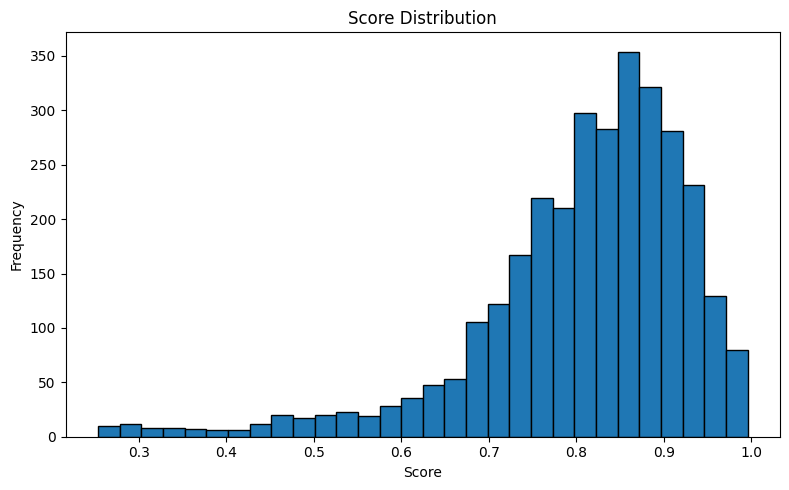

스코어 요약 통계:
count    3133.000000
mean        0.807834
std         0.123448
min         0.253500
25%         0.756400
50%         0.833900
75%         0.890800
max         0.995700
Name: score, dtype: float64


In [4]:
# 스코어 분포 히스토그램
plt.figure(figsize=(8, 5))
plt.hist(df['score'], bins=30, edgecolor='black')
plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 스코어 요약 통계
score_stats = df['score'].describe()
print("스코어 요약 통계:")
print(score_stats)

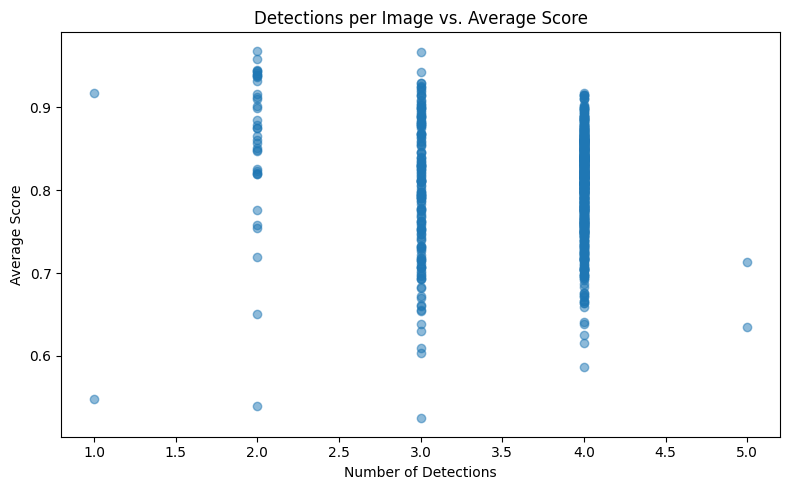

In [5]:
# 이미지별 검출 개수 vs. 평균 스코어
detections_per_image = df.groupby('image_id').agg(
    detection_count=('annotation_id', 'count'),
    avg_score=('score', 'mean')
).reset_index()

plt.figure(figsize=(8, 5))
plt.scatter(detections_per_image['detection_count'], detections_per_image['avg_score'], alpha=0.5)
plt.title('Detections per Image vs. Average Score')
plt.xlabel('Number of Detections')
plt.ylabel('Average Score')
plt.tight_layout()
plt.show()

C:\Users\yoons\AppData\Local\Temp\ipykernel_17692\2412136555.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(scores_by_cat_all, labels=[str(cid) for cid in all_category_ids], showfliers=False)


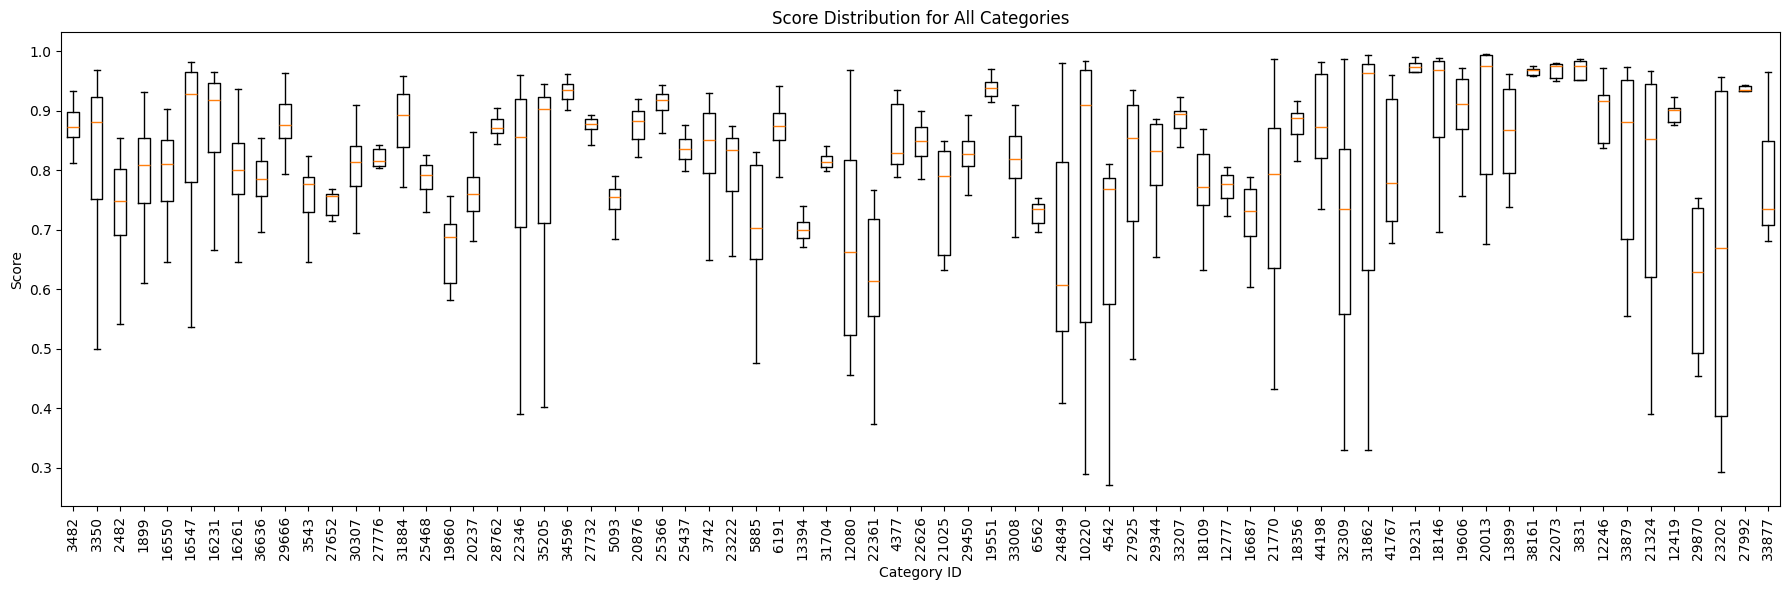

C:\Users\yoons\AppData\Local\Temp\ipykernel_17692\2412136555.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(scores_by_cat_top15, labels=[str(cid) for cid in top15_cat_ids], showfliers=False)


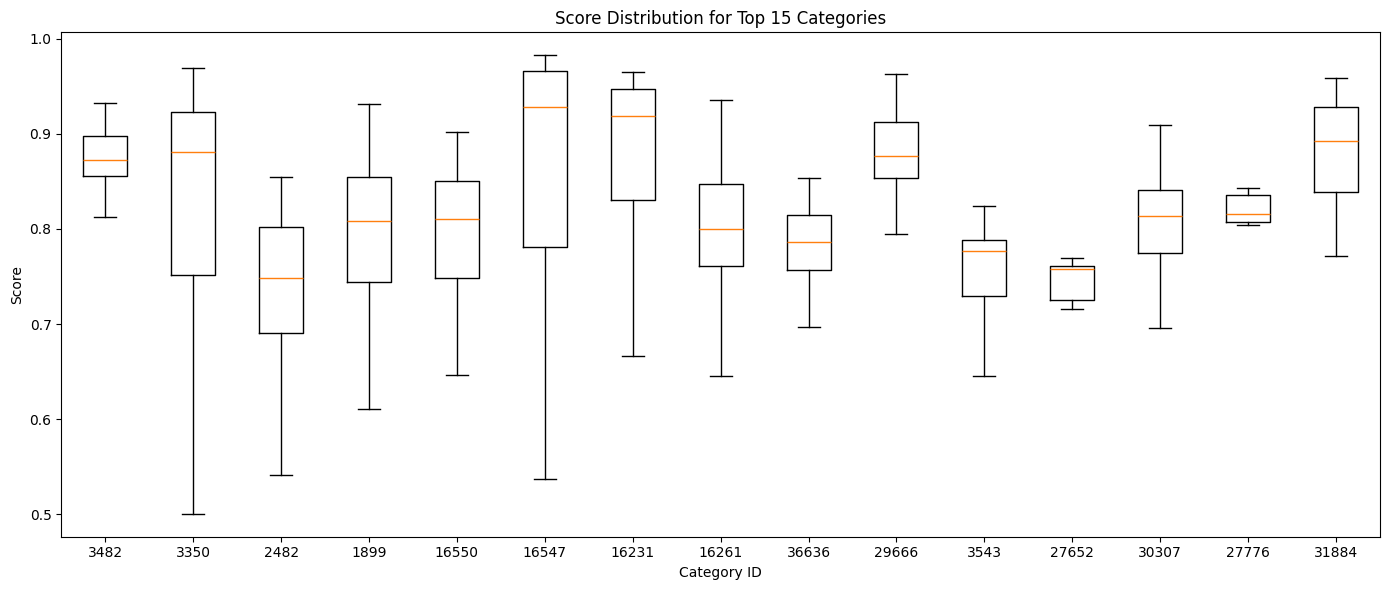

C:\Users\yoons\AppData\Local\Temp\ipykernel_17692\2412136555.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(scores_by_cat_bottom15, labels=[str(cid) for cid in bottom15_cat_ids], showfliers=False)


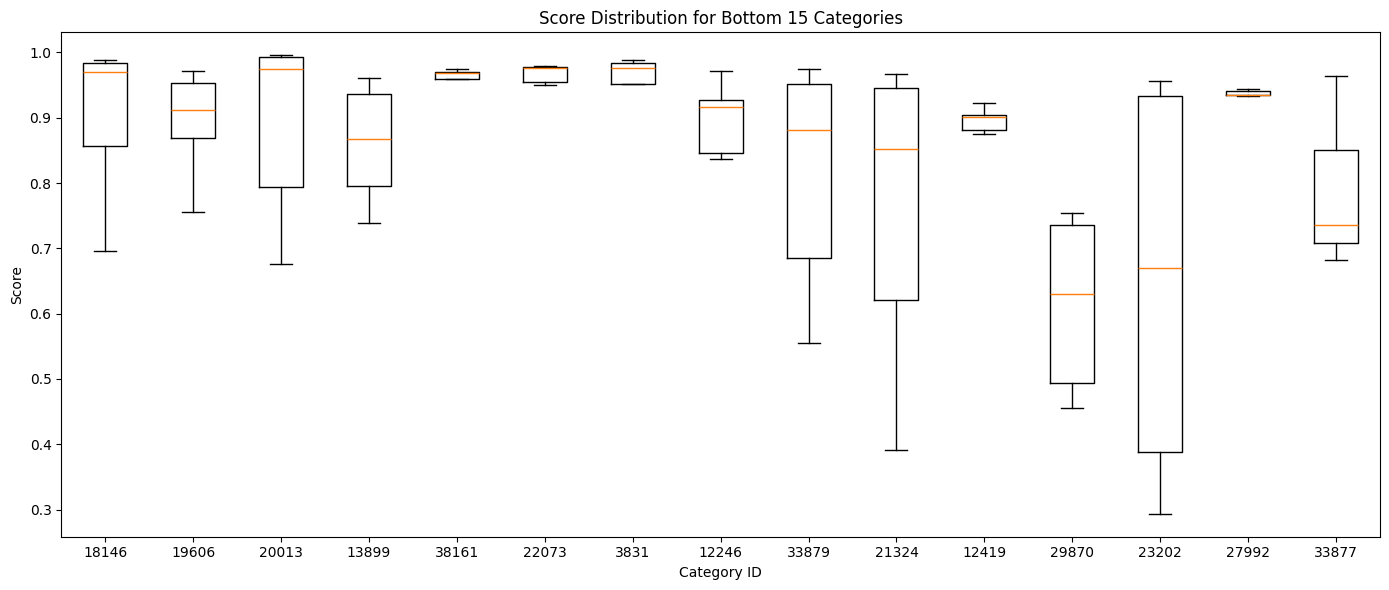

In [7]:

import matplotlib.pyplot as plt

category_stats = df.groupby('category_id').agg(
    count=('annotation_id', 'count'),
    mean_score=('score', 'mean'),
    median_score=('score', 'median')
).reset_index()
category_stats_sorted = category_stats.sort_values(by='count', ascending=False)


# 전체 카테고리 ID
all_category_ids = category_stats_sorted['category_id'].tolist()

# 상위 15개 카테고리 ID
top15_cat_ids = category_stats_sorted.head(15)['category_id'].tolist()

# 하위 15개 카테고리 ID
bottom15_cat_ids = category_stats_sorted.tail(15)['category_id'].tolist()

# 전체 카테고리 박스플롯
plt.figure(figsize=(18, 6))
scores_by_cat_all = [df[df['category_id'] == cid]['score'] for cid in all_category_ids]
plt.boxplot(scores_by_cat_all, labels=[str(cid) for cid in all_category_ids], showfliers=False)
plt.title('Score Distribution for All Categories')
plt.xlabel('Category ID')
plt.ylabel('Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 상위 15개 카테고리 박스플롯
plt.figure(figsize=(14, 6))
scores_by_cat_top15 = [df[df['category_id'] == cid]['score'] for cid in top15_cat_ids]
plt.boxplot(scores_by_cat_top15, labels=[str(cid) for cid in top15_cat_ids], showfliers=False)
plt.title('Score Distribution for Top 15 Categories')
plt.xlabel('Category ID')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

# 하위 15개 카테고리 박스플롯
plt.figure(figsize=(14, 6))
scores_by_cat_bottom15 = [df[df['category_id'] == cid]['score'] for cid in bottom15_cat_ids]
plt.boxplot(scores_by_cat_bottom15, labels=[str(cid) for cid in bottom15_cat_ids], showfliers=False)
plt.title('Score Distribution for Bottom 15 Categories')
plt.xlabel('Category ID')
plt.ylabel('Score')
plt.tight_layout()
plt.show()